In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [14]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import pystan
from scipy.interpolate import interp1d
import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

In [3]:
samples = {}
with h5py.File('observations.h5', 'r') as f:
    for k in ['m1det', 'm2det', 'dl']:
        samples[k] = array(f['posteriors'][k])

In [4]:
sel = {}
with h5py.File('selected.h5', 'r') as f:
    sel['m1det'] = array(f['m1det'])
    sel['m2det'] = array(f['m2det'])
    sel['dldet'] = array(f['dl'])
    sel['wtdet'] = array(f['wt'])
    sel['N_gen'] = f.attrs['N_gen']

In [5]:
nobs = 32
nsamp = 32
nsel = 1024

ninterp = 500

zinterp = expm1(linspace(log(1), log(11), ninterp))

mnorm = exp(arange(log(1), log(200), 0.01))

data = {
    'nobs': nobs,
    'nsel': nsel,
    'ninterp': ninterp,
    'nnorm': len(mnorm),
    
    'nsamp': nsamp*ones(nobs, dtype=np.int),
    'nsamp_total': nsamp*nobs,
    
    'Tobs': 1.0/12.0*0.5,
    'N_gen': int(round(sel['N_gen']*nsel/float(len(sel['m1det'])))),
    
    'm1obs': samples['m1det'][:nobs, :nsamp].flatten(),
    'm2obs': samples['m2det'][:nobs, :nsamp].flatten(),
    'dlobs': samples['dl'][:nobs, :nsamp].flatten(),
    
    'm1sel': sel['m1det'][:nsel],
    'm2sel': sel['m2det'][:nsel],
    'dlsel': sel['dldet'][:nsel],
    'wtsel': sel['wtdet'][:nsel],
    
    'zinterp': zinterp,
    
    'ms_norm': mnorm,
    
    'use_cosmo_prior': 1,
    'mu_H0': Planck15.H0.to(u.km/u.s/u.Mpc).value,
    'sigma_H0': 0.01*Planck15.H0.to(u.km/u.s/u.Mpc).value,
    'mu_Omh2': 0.02225+0.1198,
    'sigma_Omh2': sqrt(0.00016**2 + 0.0015**2)
}

In [11]:
model = pystan.StanModel(file='model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f4616a5bcc7a5673a9ad10b33f90c9a4 NOW.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmp9d9xjn1n/stanfit4anon_model_f4616a5bcc7a5673a9ad10b33f90c9a4_4670895898083951954.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [12]:
fit = model.sampling(data=data, iter=200, control={'metric': 'dense_e'})

In [13]:
print(fit)

Inference for Stan model: anon_model_f4616a5bcc7a5673a9ad10b33f90c9a4.
4 chains, each with iter=200; warmup=100; thin=1; 
post-warmup draws per chain=100, total post-warmup draws=400.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
H0             67.69    0.03   0.68  66.41  67.26  67.68  68.16  69.01    427   0.99
Om              0.31  3.4e-4 7.3e-3    0.3    0.3   0.31   0.32   0.32    459   0.99
w              -1.08    0.02   0.51  -2.17  -1.43  -1.07  -0.73  -0.16    859   0.99
R0             79.29    2.33  42.77  29.01  52.66  70.63  92.86 192.76    337   1.01
MMin            4.85     0.1   1.22   3.04   3.93    4.7   5.57   7.75    143    1.0
MMax            44.2    0.21   3.89  35.98  41.99  44.13  46.76  52.09    332    1.0
alpha            1.0    0.03   0.56   -0.2   0.61   1.07   1.42   1.92    314   1.01
beta           -0.34    0.03   0.56  -1.35  -0.73   -0.4   0.02    0.9    261   1.01
gamma           2.88    0.07   1.04   0.84   2.17 

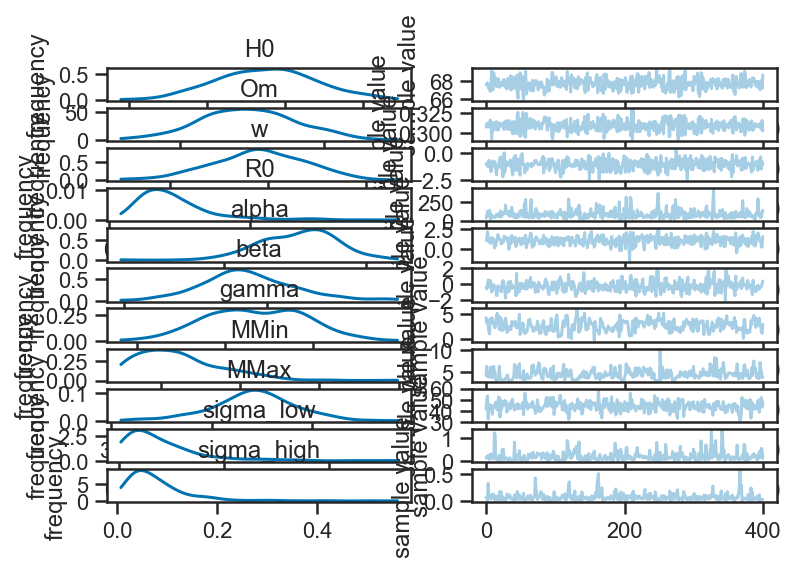

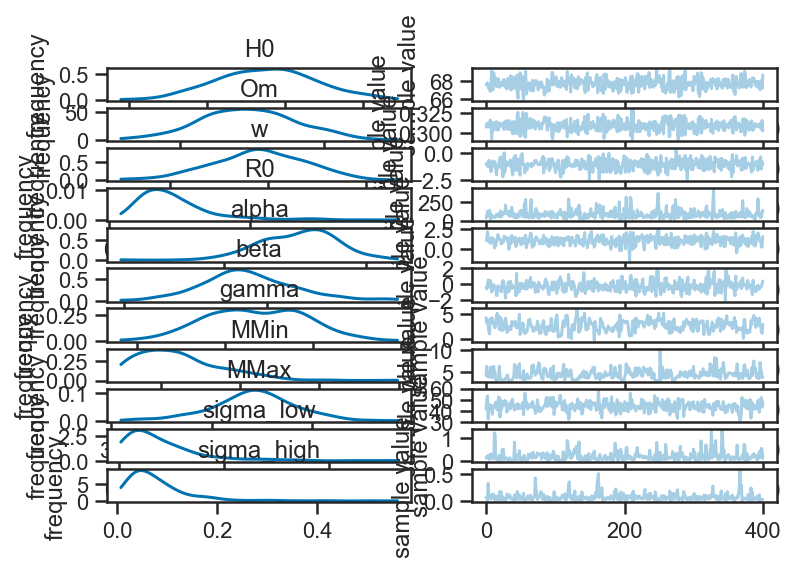

In [10]:
fit.plot(['H0', 'Om', 'w', 'R0', 'alpha', 'beta', 'gamma', 'MMin', 'MMax', 'sigma_low', 'sigma_high'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c5b36e630>,
      dtype=object)

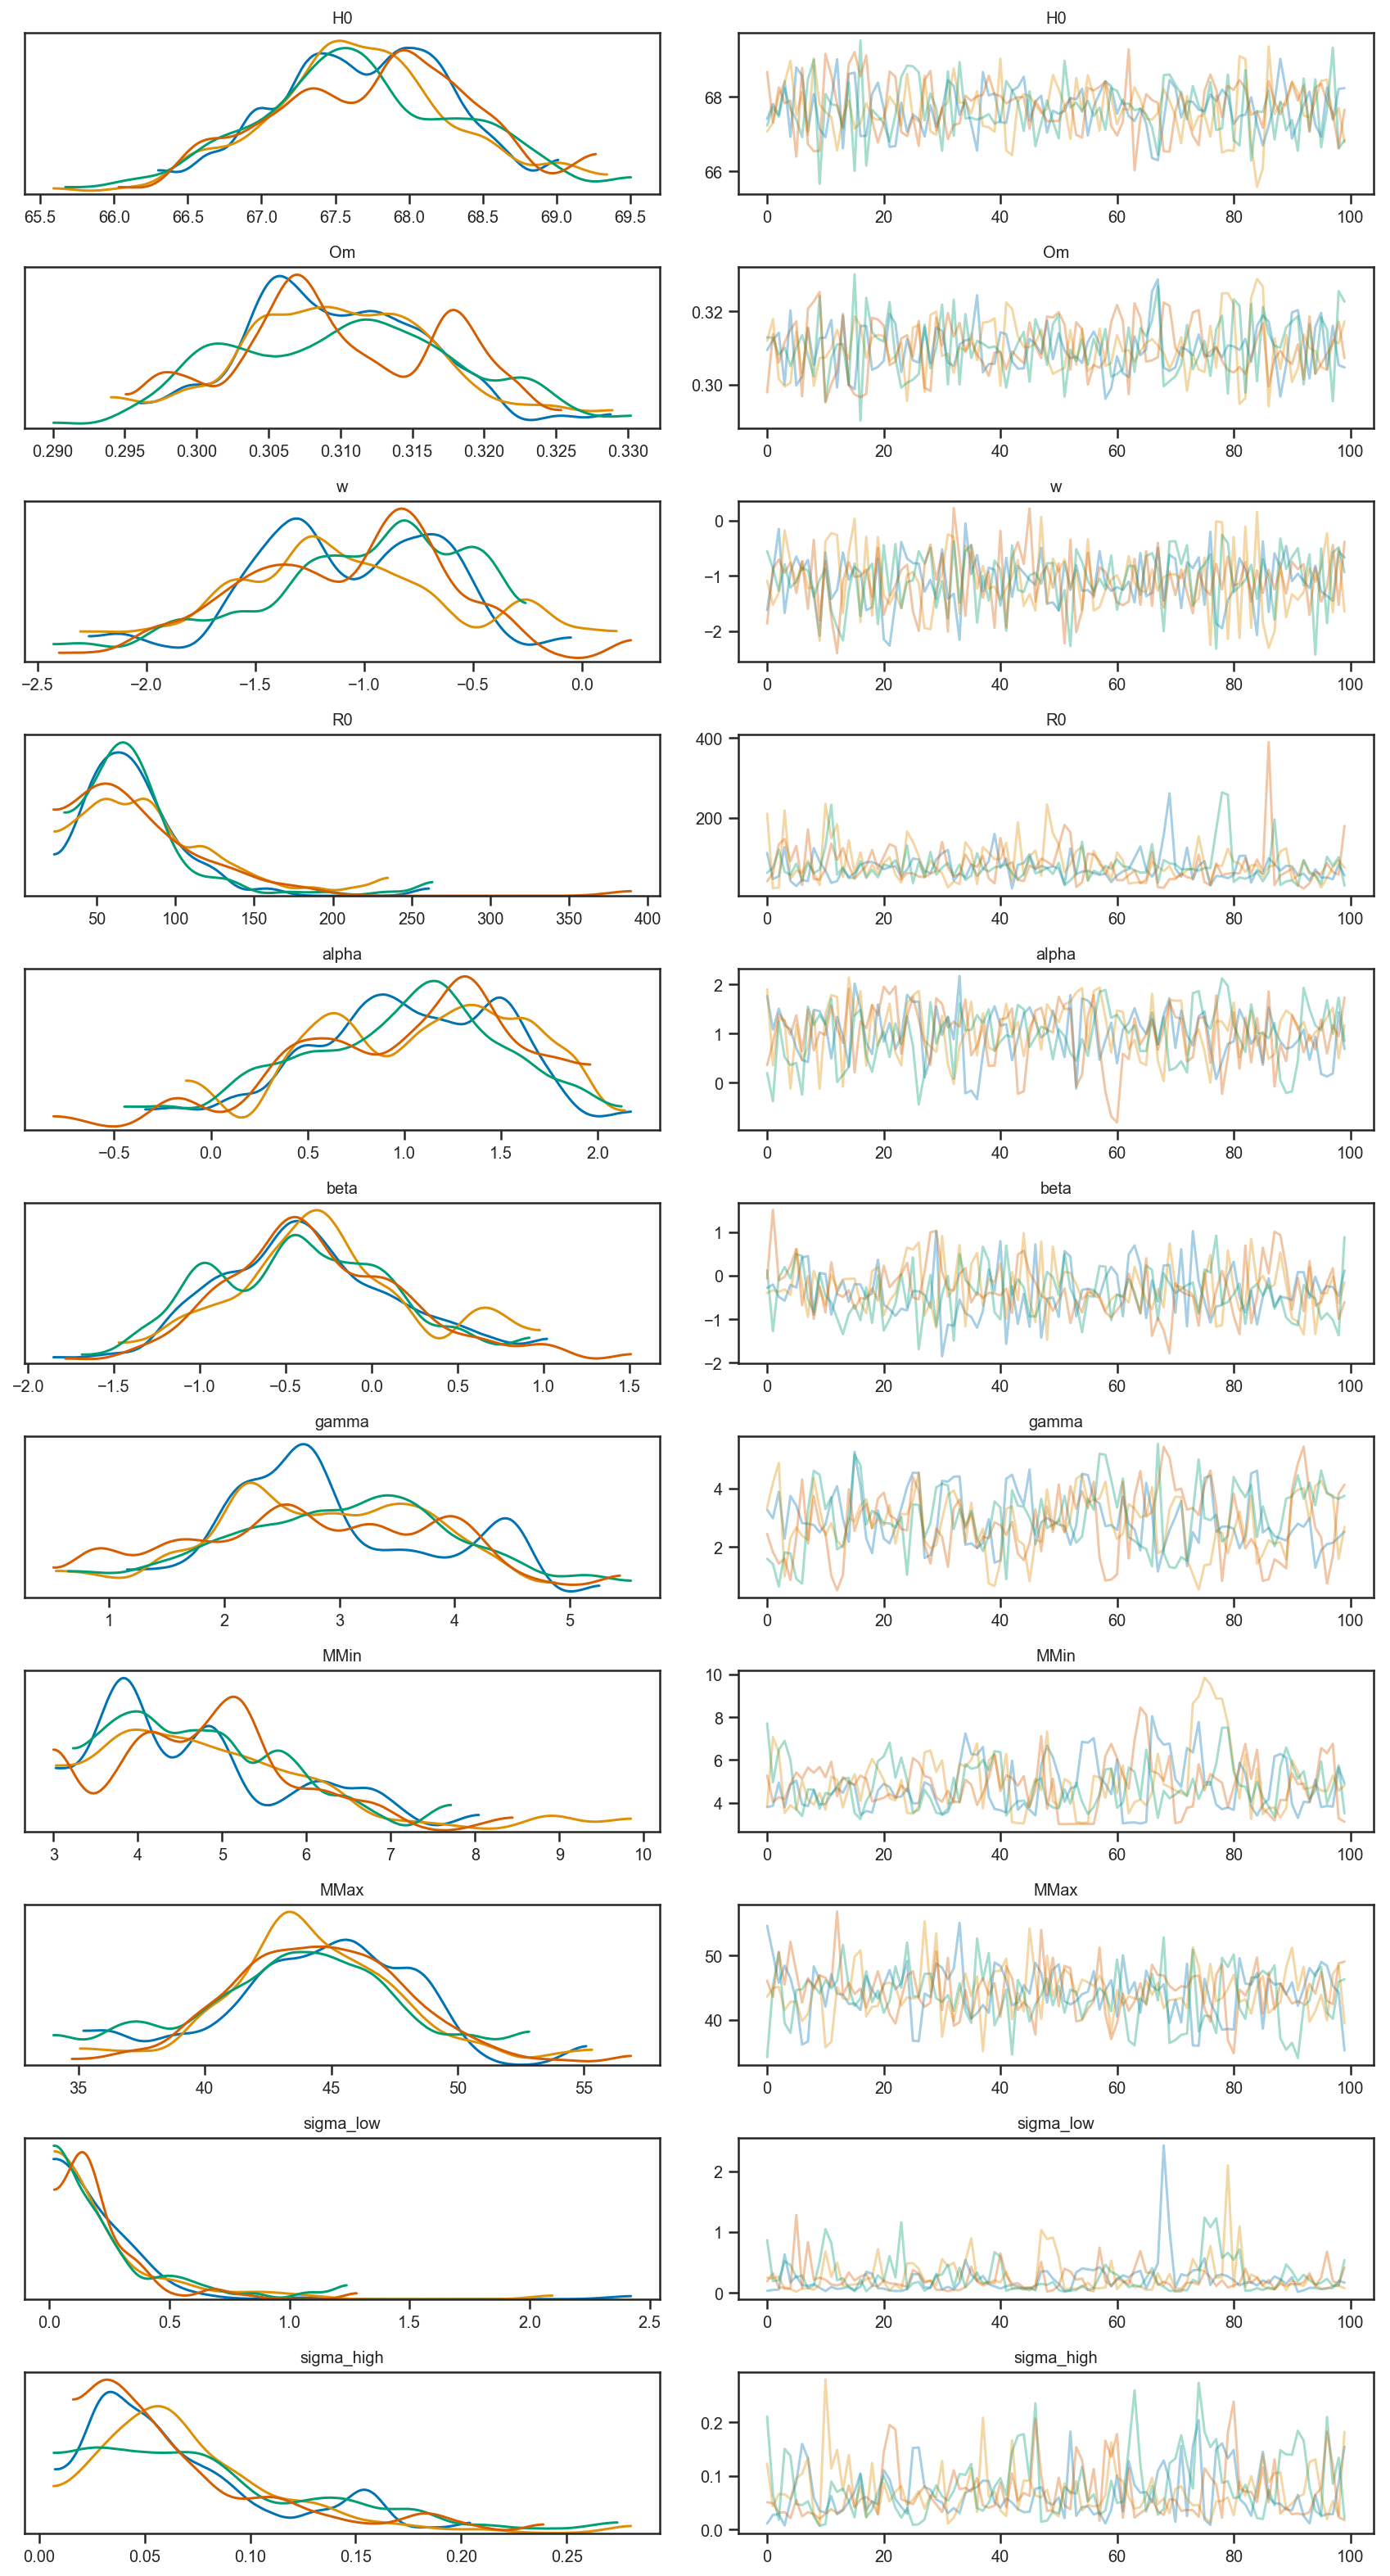

In [16]:
az.plot_trace(fit, var_names=['H0', 'Om', 'w', 'R0', 'alpha', 'beta', 'gamma', 'MMin', 'MMax', 'sigma_low', 'sigma_high'])